# Import and functions

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage

%matplotlib inline

In [20]:
import import_ipynb
try:
    os.chdir('Modules')
except:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
from time_shifted_PID import MIfunc
from time_shifted_PID import EqualState
# from StimulusnResponse import SSG
from Spike_Generation import SG
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL

In [21]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    n = np.sqrt(g)
    g = np.sqrt(g)
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

In [22]:
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

# Set Parameter

In [23]:
m = 4.037925
n =	1.0
alpha = 8.351984
beta = 3.123359
g =  442.699730
tau_y = 0.050404

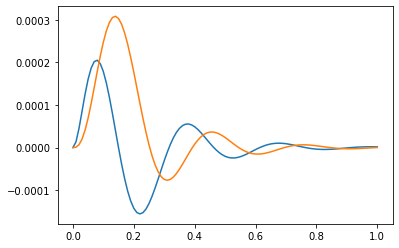

In [24]:
dt = 0.01
TKaxis = np.arange(101)*dt

k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)

Text(0.5, 1.0, 'group delay')

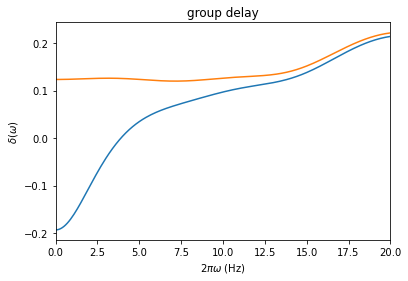

In [25]:
df = 0.1
faxis = np.arange(-50,50,df)

F_TK = np.sum(k_E[np.newaxis,:]*np.exp(-1j*TKaxis[np.newaxis,:]*faxis[:,np.newaxis]), axis = 1)*dt
Phi = np.angle(F_TK)
delta = -angular_gradient(Phi)/df
plt.plot(faxis, delta)
F_TK = np.sum(k_S*np.exp(-1j*TKaxis[np.newaxis,:]*faxis[:,np.newaxis]), axis = 1)*dt
Phi = np.angle(F_TK)
delta = -angular_gradient(Phi)/df
plt.plot(faxis, delta)
plt.ylabel(r'$\delta(\omega)$')
plt.xlabel(r'2$\pi\omega$ (Hz)')
plt.xlim([0,20])
plt.title('group delay')

# WF(LPOU)+GC

In [26]:
#Gain control function
def gain_func(v):
    try: # if v is an ndarray
        v[v < 0] = 0
    except: # if v is a variable
        if v < 0 : return 1
    return 1/(1+v**4)
    
def AddGainControl(r, B, tau):
    decay = np.exp(-(np.arange(0,1,dt)+dt)/tau)
    # plt.plot(np.arange(0,1,dt)+dt,decay)

    output = np.zeros_like(r)
    gain = np.zeros_like(r)
    for i in np.arange(1,r.shape[0]):
        gain[i] = gain_func(np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt) )
        opi = gain[i]*r[i]
        output[i] = opi
    output[output<0] = 0
    return  output, gain

In [27]:
tot = 1000
Taxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(Taxis))
mu, sigma = 0, 1
for i in range(len(Taxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
x = (LPOU-np.mean(LPOU))/np.std(LPOU)

In [28]:
amp = 2
mean = 10
baseOutput = np.convolve(x*amp+mean, k_E, 'full')[:len(x)]

In [29]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt

x = np.array(LPOU)
x = (x-np.mean(x))/np.std(x)

r = baseOutput
r = NL(r, np.mean(r))
Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
baseXcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]

In [30]:
tv = ndimage.gaussian_filter1d(LPOU, order=1, sigma=1)/dt
#assign states
state_num = 6
xstate = EqualState(LPOU, state_num)[0]
tvstate = EqualState(tv, state_num)[0]

baserstate = SG(baseOutput, dt, 0, 10, 10)
timeshift, baseMI = MIfunc(baserstate, xstate, dt, window)

# CCDM

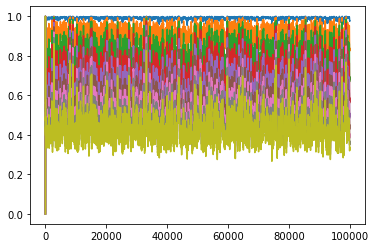

In [31]:
B = 1000 #To tune altitude of gain control (D=1/T)
tau = 0.3
mag_list = np.arange(0.2,2.,0.2)
CCDM_output = [0]*len(mag_list)
for i in range(len(mag_list)):
    output = np.convolve( (x*amp+mean)*mag_list[i] , k_E, 'full')[:len(x)]
    # output = NL(output, np.mean(output))
    CCDM_output[i], gain = AddGainControl(output, B, tau) # GC after rectifier
    plt.plot(gain) # make sure the value of gain is good

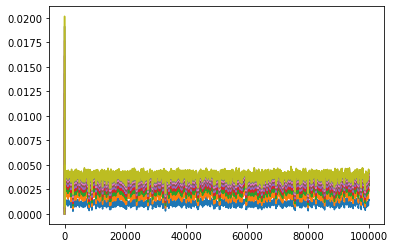

In [32]:
# plt.plot(baseOutput)
for i in range(len(mag_list)):
    plt.plot(CCDM_output[i])
# plt.xlim(45000,46000)

### STA

In [33]:
x = np.array(LPOU)
x = (x-np.mean(x))/np.std(x)

CCDM_Xcorr = [0]*len(mag_list)
for i in range(len(mag_list)):
    r = CCDM_output[i] 
    r = NL(r, np.mean(r))
    Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    CCDM_Xcorr[i] = Xcorr.copy()

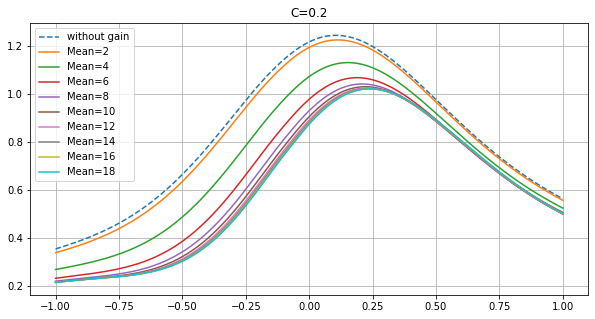

In [34]:
plt.plot(timeaxis,baseXcorr, label= 'without gain', linestyle= 'dashed' )
for i in range(len(mag_list)): 
    plt.plot(timeaxis,CCDM_Xcorr[i], label = 'Mean='+str(round(mag_list[i]*mean)))
plt.legend()
plt.title('C='+str(amp/mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

### MI

In [35]:
CCDM_MI = [0]*len(mag_list)
for i in range(len(mag_list)):
    # rstate, _ = np.histogram( Spike_Time_Generater(CCDM_output[i], dt, 10, 10), np.append(Taxis, tot))
    rstate =SG(CCDM_output[i], dt, 0, 10, 10)
    timeshift, CCDM_MI[i] = MIfunc(rstate, xstate, dt, window)

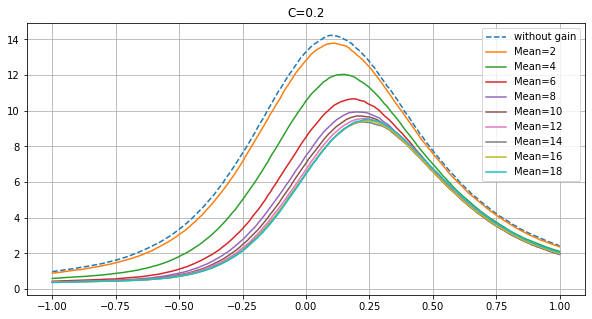

In [36]:
plt.plot(timeaxis,baseMI, label= 'without gain', linestyle= 'dashed' )
for i in range(len(mag_list)): 
    plt.plot(timeaxis,CCDM_MI[i], label = 'Mean='+str(round(mag_list[i]*mean)))
plt.legend()
plt.title('C='+str(amp/mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)